# MiniDataChallengeSteering for auxiliary telescope

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import re
%matplotlib inline

In [2]:
from astropy.io import fits

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [5]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [6]:
%load_ext autoreload
%autoreload 2

# Initialisation

## Python Packages

In [7]:
PATH_LSSTFiltersKG='./LSSTFiltersKG'
PATH_ATMPARAMSIM='./atmparamsim'
PATH_ATMTRANSPSIM='./libradtransim'
PATH_CADENCE='./cadence'
PATH_LSSTPHOTO='./lsstphotometry'
PATH_SED='./pysynphotsed'

In [8]:
sys.path.append(PATH_LSSTFiltersKG)
sys.path.append(PATH_ATMPARAMSIM)
sys.path.append(PATH_ATMTRANSPSIM)
sys.path.append(PATH_CADENCE)
sys.path.append(PATH_LSSTPHOTO)
sys.path.append(PATH_SED)

In [9]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTPhotometry as photo
import libLSSTFiltersKG as lsst
import libpysynphotgridsed as sed

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


## Input file

### Simulation from LSST

- the file has been generated from cadence and atmospheric variation in **MiniDataChallengeSteer.ipynb**

In [10]:
packet=1
packetsize=50

In [11]:
string_tag='cadence_field1000_atm_calibration_'
cadence_atm_program_file=string_tag+str(packet)+'.fits'
NROWMIN=(packet-1)*packetsize
NROWMAX=(packet)*packetsize-1
print 'file=',cadence_atm_program_file,' NROWMIN=',NROWMIN,' NROWMAX=',NROWMAX

file= cadence_field1000_atm_calibration_1.fits  NROWMIN= 0  NROWMAX= 49


### catalog of series of selected SED

sed_file=os.path.join(PATH_SED,'sedgrid_phoenixmodels_selected1000.fits')

- the catalog has been created by **PATH_SED/libpysynphotsed.py** in the fits file sedgrid_phoenixmodels_all.fits
- A number of 1000 SED has been sampled by **SelectSED.ipynb**

In [12]:
file_sed_fits=os.path.join(PATH_SED,'sedgrid_phoenixmodels_selected1000.fits')

## Output file

- file with star magnitudes from which one must retrieve atmospheric parameters from the star magnitudes

In [13]:
#output_file='cadence_field1000_atm_calibration_auxtel_1.fits'
output_file=string_tag+'auxtel_'+str(packet)+'.fits'
output_file

'cadence_field1000_atm_calibration_auxtel_1.fits'

In [14]:
idx_out_num=0
idx_out_night=1
idx_out_expdate=2
idx_out_expmjd=3
idx_out_am=4
idx_out_filt=5
idx_out_vaod=6
idx_out_pwv=7
idx_out_o3=8
idx_out_res=9
idx_out_mag=10 # index where the spectrum of star starts

# Extraction of atmospheric data

In [15]:
hdu=fits.open(cadence_atm_program_file)

In [16]:
hdu.info()

Filename: cadence_field1000_atm_calibration_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (1010, 49)   float64   


## Header 

- goal to decode index

In [17]:
hdr=hdu[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1010                                                  
NAXIS2  =                   49                                                  
NBSED   =                 1000                                                  
NBATMSIM=                   49                                                  
ID_NUM  =                    0                                                  
ID_NIGHT=                    1                                                  
ID_DATE =                    2                                                  
ID_EXMJD=                    3                                                  
ID_AM   =                    4                                                  
ID_FILT =                   

In [18]:
idx_num=hdr['ID_NUM']
idx_night=hdr['ID_NIGHT']
idx_expdate=hdr['ID_DATE']
idx_expmjd=hdr['ID_EXMJD']
idx_am=hdr['ID_AM']
idx_filt=hdr['ID_FILT']
idx_vaod=hdr['ID_VAOD']
idx_pwv=hdr['ID_PWV']
idx_o3=hdr['ID_O3']
idx_res=hdr['ID_RES']
idx_mag=hdr['ID_MAG'] # index where the spectrum of star starts

## Extract atmospheric parameters from data

In [19]:
atmdata=hdr=hdu[0].data

In [20]:
all_am=atmdata[:,idx_am]
all_vaod=atmdata[:,idx_vaod]
all_pwv=atmdata[:,idx_pwv]
all_o3=atmdata[:,idx_o3]

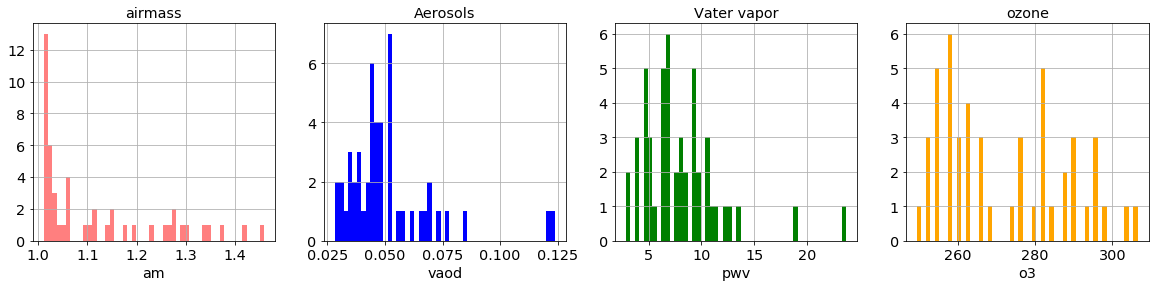

In [21]:
f, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(20,4))
ax1.hist(all_am,bins=50,color='red',alpha=0.5);
ax1.set_title('airmass')
ax1.set_xlabel('am')
ax1.grid()
ax2.hist(all_vaod,bins=50,color='blue');
ax2.set_title('Aerosols')
ax2.set_xlabel('vaod')
ax2.grid()
ax3.hist(all_pwv,bins=50,color='green');
ax3.set_title('Vater vapor')
ax3.set_xlabel('pwv')
ax3.grid()
ax4.hist(all_o3,bins=50,color='orange');
ax4.set_title('ozone')
ax4.set_xlabel('o3')
ax4.grid()
plt.show()

# Read the SED

In [22]:
hdu2 = fits.open(file_sed_fits)

## The header

In [23]:
hdr2=hdu2[0].header

In [24]:
index_num=hdr2["IDX_NUM"]
index_val=hdr2["IDX_VAL"]
index_temp=hdr2["IDX_TEMP"]
index_logg=hdr2["IDX_LOGG"]
index_logz=hdr2["IDX_LOGZ"]
index_spec=hdr2["IDX_SPEC"]
index_mag=hdr2["IDX_MAG"]

## Star Simulation parameter

In [25]:
star_param=hdu2[0].data[1:,sed.index_temp:sed.index_spec]

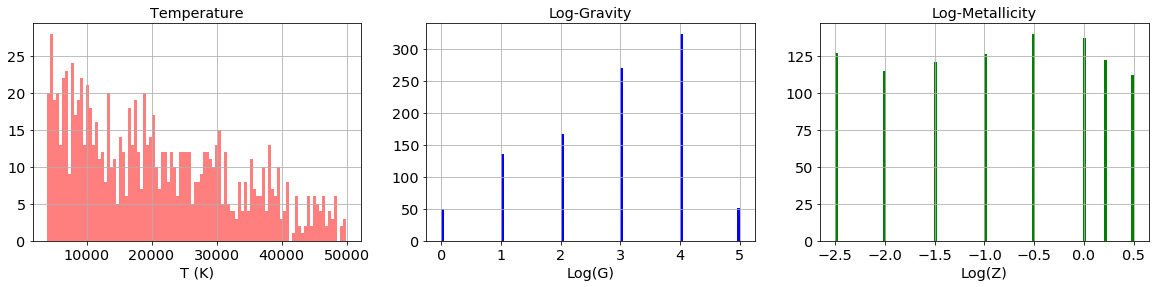

In [26]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.hist(star_param[:,0],bins=100,color='red',alpha=0.5);
ax1.set_title('Temperature')
ax1.set_xlabel('T (K)')
ax1.grid()
ax2.hist(star_param[:,1],bins=100,color='blue');
ax2.set_title('Log-Gravity')
ax2.set_xlabel('Log(G)')
ax2.grid()
ax3.hist(star_param[:,2],bins=100,color='green');
ax3.set_title('Log-Metallicity')
ax3.set_xlabel('Log(Z)')
ax3.grid()
plt.show()

In [27]:
NBSED=hdu[0].data.shape[0]-1

In [28]:

NBSED

48

# Retrieve one SED 

In [29]:
ISED=500

In [30]:
WL=hdu2[0].data[0,sed.index_spec:]
flux=hdu2[0].data[ISED,sed.index_spec:]

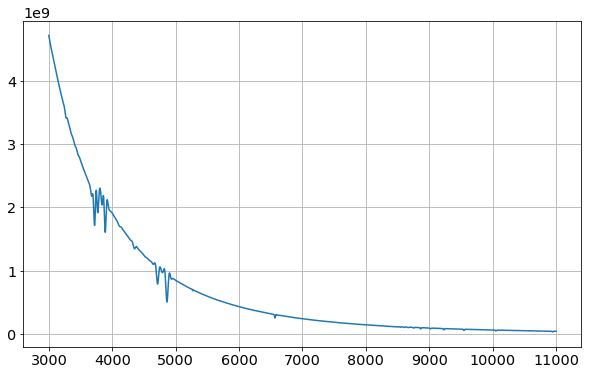

In [31]:
plt.plot(WL,flux)
plt.grid()

In [32]:
all_sed_collection= []
all_sedmodels_tag=[]

In [33]:
Flag_PHOENIX=True       
if Flag_PHOENIX:
    all_sed,all_indexes=sed.FitsToPySynphotSED(file_sed_fits)
    all_sed_collection.append(all_sed)
    all_sedmodels_tag.append('phoenix')

Warning, 56 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 14 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 24 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 8 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 24 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 20 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 8000 bins contained negative fluxes; they have been set to zero.
Warning, 25 of 8000 bins contained negative f

# number of different catalogs

In [34]:
NBCATALOGS=len(all_sedmodels_tag)

# Retrieve the LSST filters
- those filter in which one will calculate the magnitudes

In [35]:
wl,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE('.')
total_transm=throughput*ccdqe*trans_opt_elec

Text(0,0.5,'transmission')

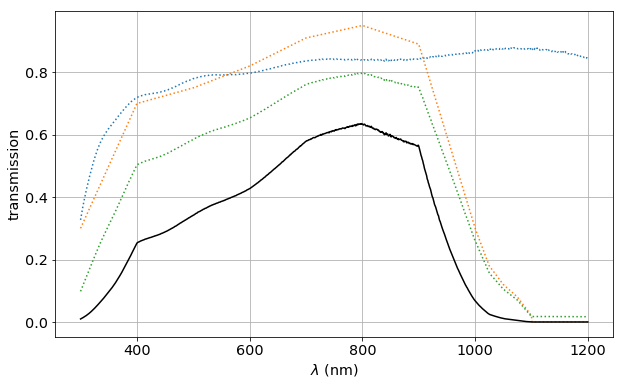

In [36]:
plt.plot(wl,throughput,':')
plt.plot(wl,ccdqe,':')
plt.plot(wl,trans_opt_elec,':')
plt.plot(wl,total_transm,'k-')
plt.grid()
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('transmission')

In [37]:
bp=lsst.GetAllLSSTransmission('.')

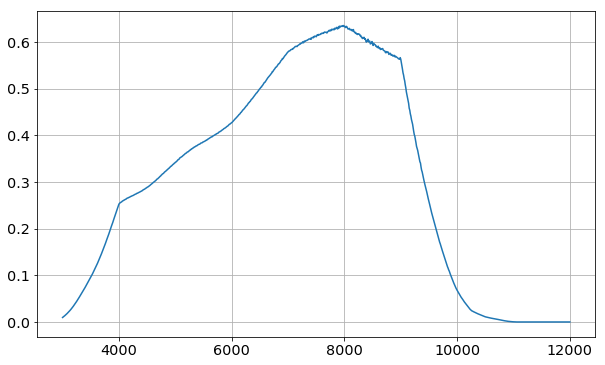

In [38]:
plt.plot(bp.wave,bp.throughput)
plt.grid()

In [39]:
auxtel=photo.LSSTAuxTelTransmission('auxtel')

In [40]:
auxtel.fill_det_band(bp) 

## Atmospheric simulation

In [41]:
#NbAtmSimul=10
lambda0_aerosol=500. # nm

In [42]:
photo_atm=photo.Atmosphere('libradtran')

In [43]:
index=0
NbAtmSimul=len(all_am)
while index<NbAtmSimul:
    am=all_am[index]
    pwv=all_pwv[index]
    ozone=all_o3[index]
    tau_aerosol=all_vaod[index]
    print '**************************************************************************************************'
    print '*  atmospheric simulation with libradtran : idx=',index,' am=',am,' vaod=',tau_aerosol,' pwv=',pwv,' O3=',ozone ,' *'
    '********************************************************************************************************'
    path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol) 
    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]  
    if index==0:
        photo_atm.fill_array(wl_atm)        
    photo_atm.fill_array(tr_atm)        
    index+=1

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 0  am= 1.370996  vaod= 0.046569136376  pwv= 2.82308303298  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.370996
 2) pwv =  2.82308303298
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv28_oz28_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 1  am= 1.274001  vaod= 0.0526745196272  pwv= 8.63941059655  O3= 262.935592067  *
--------------------------------------------
 1) airmass =  1.274001
 2) pwv =  8.63941059655
 3) oz =  262.935592067
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
------------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 16  am= 1.347676  vaod= 0.0302881143729  pwv= 19.108800211  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.347676
 2) pwv =  19.108800211
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0302881143729
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv191_oz25_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 17  am= 1.266911  vaod= 0.0343583698736  pwv= 9.80267610927  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.266911
 2) pwv =  9.80267610927
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0343583698736
---------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 31  am= 1.025254  vaod= 0.0445340086256  pwv= 6.89451232748  O3= 282.032861132  *
--------------------------------------------
 1) airmass =  1.025254
 2) pwv =  6.89451232748
 3) oz =  282.032861132
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv68_oz28_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 32  am= 1.058005  vaod= 0.0445340086256  pwv= 6.31287957112  O3= 303.858311491  *
--------------------------------------------
 1) airmass =  1.058005
 2) pwv =  6.31287957112
 3) oz =  303.858311491
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------

In [44]:
theatmosph=photo_atm.get_array()

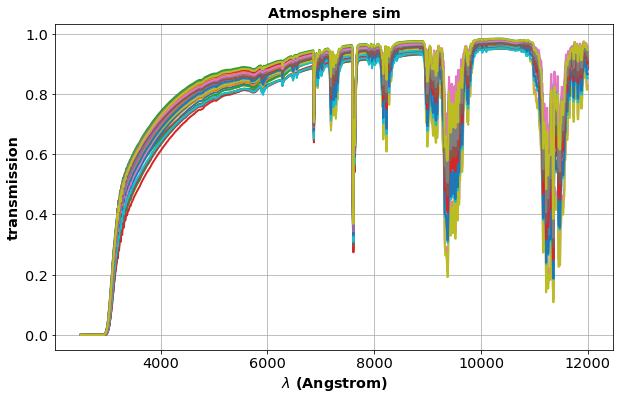

In [45]:
photo_atm.plot_pys_bp()

In [46]:
all_bp_atm=photo_atm.get_pys_pb()

In [47]:
auxtel.fill_atm_allevents(all_bp_atm)

In [48]:
all_transmissions=auxtel.make_transmissions()

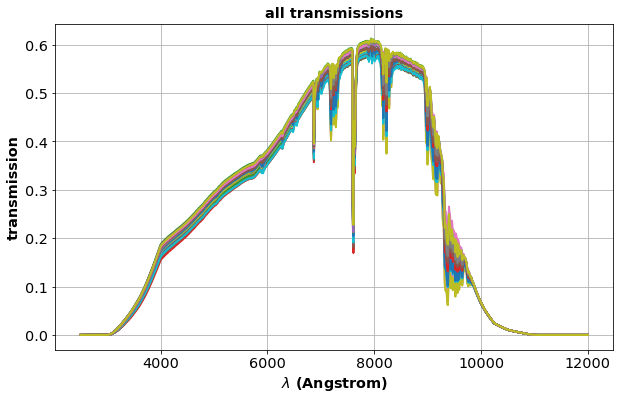

In [49]:
auxtel.plot_transmissions()

# Calculation of all Observations for each SED colors

In [50]:
all_observations_collection = []
all_observations_zeropt_collection = []
all_sed=[all_sed]

In [51]:
for id_model in np.arange(NBCATALOGS):
    the_obs_name="LSST_starmodels-{}".format("phoenix")  
    the_observation=photo.LSSTAuxTelObs(the_obs_name)            # create a set of observation 
    the_observation.fill_sed(all_sed_collection[id_model])         # get the SED from the SED model model
    the_observation.fill_transmission(all_transmissions)           # provide LSST Trroughput transmission
    the_observation.make_observations()                            # start calculations 
    the_observation.make_samplobservations()
    #the_observation.compute_counts()
    #the_observation.compute_magnitude()
    #the_observation.compute_colors()
    #all_observations_collection.append(the_observation)

((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10

((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10

((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1

((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_20 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_21 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_5 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_6 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_

((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_37 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_38 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_39 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_22 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_40 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_41 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_23 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_24 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_25 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_26 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_7 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_8 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_9 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_10 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((A

((ATM_42 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((

((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_35 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_36 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_19 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_43 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_44 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_45 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(

((ATM_27 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_28 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_29 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_30 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_31 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_32 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_33 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_34 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_11 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_12 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_13 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_14 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_15 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_16 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_17 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_18 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((ATM_46 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_47 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_48 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_49 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_1 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_2 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_3 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((ATM_4 * LSST_OPT)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((AT

In [52]:
ModelSelect=0
ObjectSelect=0

In [53]:
all_observations_collection[ModelSelect].plot_samplobservations(ObjectSelect)

IndexError: list index out of range

In [ ]:
ObjectSelect=100

In [ ]:
all_observations_collection[ModelSelect].plot_samplobservations(ObjectSelect)

# output file

In [ ]:
NBROW=NbAtmSimul
NBCOL=idx_out_mag+NBSED

In [ ]:
data_out=np.zeros((NBROW,NBCOL))

In [ ]:
all_mag=all_observations_collection[ModelSelect].get_magnitudes()

In [ ]:
for idx in np.arange(NBROW):
    data_out[idx,idx_out_num]=idx
    data_out[idx,idx_out_night]=df['nights'].iloc[idx]
    data_out[idx,idx_out_expdate]=df['expdate'].iloc[idx]
    data_out[idx,idx_out_expmjd]=df['expmjd'].iloc[idx]
    data_out[idx,idx_out_am]=df['airmass'].iloc[idx]
    filtnum=photo.band_to_number_2[df['filter'].iloc[idx]] # convert filter into number
    data_out[idx,idx_out_filt]=filtnum
    data_out[idx,idx_out_vaod]=df['vaod'].iloc[idx]
    data_out[idx,idx_out_pwv]=df['pwv'].iloc[idx]
    data_out[idx,idx_out_o3]=df['o3'].iloc[idx]
    data_out[idx,idx_out_res]=0
    for ised in np.arange(NBSED):
        data_out[idx,idx_out_mag+ised]=all_mag[ised,idx,filtnum]

In [ ]:
plt.imshow(data_out)

In [ ]:
hdr = fits.Header()
hdr['NBSED'] = NBSED
hdr['NBATMSIM']=NbAtmSimul
hdr['ID_NUM']=idx_out_num
hdr['ID_NIGHT']=idx_out_night
hdr['ID_DATE']=idx_out_expdate
hdr['ID_EXMJD']=idx_out_expmjd
hdr['ID_AM']=idx_out_am
hdr['ID_FILT']=idx_out_filt
hdr['ID_VAOD']=idx_out_vaod
hdr['ID_PWV']=idx_out_pwv
hdr['ID_O3']=idx_out_o3
hdr['ID_RES']=idx_out_res
hdr['ID_MAG']=idx_out_mag 

hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu.writeto(output_file,overwrite=True)